# Spark Tutorial

During the last few decades, we have witnessed an exponential growth of the volume of data. Terms such as Big Data and the data deluge have been coined to describe the situation. The data that has to be processed is too large for a single machine, even when we take high-end servers with hundreds of GBs of main memory into account. A viable solution is to use multiple machines in order to process this data, to scale-out.

To this end, several distributed systems have been proposed. Spark is one of the most popular options and it is open-source and general-purpose. It leverages in-memory processing to significantly outperform its predecessors such as Hadoop MapReduce (though they have many common components such as Yarn and HDFS). Its programming model relies on RDD and transformations on them. More on that soon! 

## Setting up the environment

Before using Spark functionality, we have to set up the environment. First, we import the modules required for the examples in this tutorial. Then, we create a Spark session which provides an entry point for interacting with Spark and allows programming Spark with DataFrame and Dataset APIs.

In [8]:
import re
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import findspark
findspark.init()

from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.functions import min

from pyspark.sql import SparkSession
from pyspark import SparkContext

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

Next download the data and set the path to the directory where they are stored. <br>
Link: https://drive.google.com/drive/folders/1jV0NLcjhs98OLpEE0AaDdJvAfVJipMv1

In [35]:
#example for data directory at notebook's directory
DATA_DIR = 'data/'

Now, we have to load the data from the files and create the corresponding RDDs by using the following statements:

In [36]:
titles_rdd = sc.textFile(DATA_DIR+'titles.csv') \
                .map(lambda line: line.strip().split('|')) \
                .filter(lambda r: len(r) == 9)
ratings_rdd = sc.textFile(DATA_DIR+'ratings.csv') \
                .map(lambda line: line.strip().split('|')) \
                .filter(lambda r: len(r) == 3)

In [37]:
titles_rdd.count()

1620153

In [38]:
ratings_rdd.count()

875804

## Warming up with sparks

The dataset we are using for this tutorial is the well-known IMDB dataset, We use the title and rating tables with the following schemas: <br>
id|type|name|original name|adult|start year|end year|running time|genre list <br>
id|rating|votes

We will start with some basic Spark operations. Let's suppose we are interested in the movies that were published in 1995.

In [12]:
#filter movie and 1995
movies1995_rdd = titles_rdd.filter(lambda r: r[1] == 'movie' and r[5] == '1995')

Then, we can get the number of such movies with the statement:

In [13]:
#count
movies1995_rdd.count()

4001

One of most common transformation operations in Spark, and the MapReduce model in general, is map, which applies a function to the elements of an RDD and returns an RDD with the results. For example, we can transform the ratings to the 100 scale. 

In [14]:
#map(lambda (id,rating,votes) : (id, int(10*rating),votes))
def tofloat(n) :
    try:
        float(n)
        return float(n)
    except ValueError:
        return -1.0
    
def toint(n) :
    try:
        int(n)
        return int(n)
    except ValueError:
        return -1
    
ratings100_rdd = ratings_rdd.map(lambda r: (r[0], int(10*tofloat(r[1])), toint(r[2])))
#filter those with over 97 and collect print
ratings95plus_rdd = ratings100_rdd.filter(lambda r: r[1] >= 95)
ratings95plus_rdd.count()

10825

Other transformations also exist, such as flatMap and reduceByKey. Transformations can also be applied in a sequence to perform more complex computations.

Let's suppose we want to compute the number of movies per genre.

In [15]:
#flatMap and reduceByKey
genres_rdd = titles_rdd.flatMap(lambda r: [(r[0], g) for g in r[8].split(',')])
genre_frequency = genres_rdd.map(lambda r: (r[1],1)).reduceByKey(lambda a,b: a+b)
genre_frequency.take(10)
#maybe have groupby example somewhere?

[('Short', 693890),
 ('Romance', 74072),
 ('Sport', 24891),
 ('Drama', 440121),
 ('Fantasy', 43305),
 ('Western', 13478),
 ('Family', 61350),
 ('Sci-Fi', 37671),
 ('Thriller', 61328),
 ('Musical', 20398)]

Then, we can also use the transformations of Spark in order to get the ten most common genres.

In [16]:
genre_frequency.sortBy(lambda r: r[1], ascending = False).take(10)

[('Short', 693890),
 ('Drama', 440121),
 ('Comedy', 314054),
 ('Documentary', 280118),
 ('\\N', 119723),
 ('Action', 85652),
 ('Music', 82110),
 ('Romance', 74072),
 ('Animation', 68966),
 ('Horror', 66782)]

Also, we can combine different RDDs by using transformations such as joins, unions and intersections. For instance, to get movies with ratings over 95% which were produced after 2000:

In [17]:
#join, filter, filter, collect
titles_rdd.filter(lambda r: r[1] == 'movie' and r[5].isdigit() and int(r[5]) > 2000) \
            .map(lambda r: (r[0],r[2])) \
            .join(ratings95plus_rdd) \
            .take(10)

[('tt1711364', ('A3D Ayumi Hamasaki Arena Tour 2009 A: Next Level', 95)),
 ('tt4075214', ('Birmingham Ornament', 97)),
 ('tt4418908', ('Memoirs of a Broken Mind', 96)),
 ('tt4656004', ('Mémoire', 95)),
 ('tt5122222', ('Flaugstad', 95)),
 ('tt5612400', ('Summer Days: Good Day Sunshine', 95)),
 ('tt6074834', ('Delaware Shore', 96)),
 ('tt6112220', ('The Butterfly Effect', 95)),
 ('tt6289570', ('Ufrivillig', 97)),
 ('tt6325188', ('Somewhere Over That Rainbow', 100))]

Also, we can use more complex functions with our transformations. To get titles that match with "Lord of the Rings", we can combine regular expressions and other functions.

In [18]:
regexp = re.compile("lord.*rings")
titles_rdd.filter(lambda r: regexp.search(r[2].lower()) != None).map(lambda r: r[2]).take(5)


['The Lord of the Rings',
 'The Lord of the Rings: The Fellowship of the Ring',
 'Lord of the Rings',
 'The Lord of the Rings: The Return of the King',
 'The Lord of the Rings: The Two Towers']

As we explained in the class, Spark also offers its own DataFrame abstraction. We can convert our RDDs by giving them a structure.

In [19]:
titles_rows = titles_rdd.map(lambda r: Row(id=r[0], type=r[1], title=r[2], year=r[5],runtime=r[7],genres=r[8]))
ratings_rows = ratings100_rdd.map(lambda r: Row(id=r[0],rating=r[1],votes=r[2]))

titles = spark.createDataFrame(titles_rows)
ratings = spark.createDataFrame(ratings_rows)

Also, we can store our data using Apache Parquet. Parquet is a columnar, horizontally-partitioned storage format that supports compression and efficient access. Therefore, it is ideal for Hadoop applications such as Spark.

In [20]:
titles.write.mode('overwrite').parquet("titles.parquet")
ratings.write.mode('overwrite').parquet("ratings.parquet")

In [21]:
titles = spark.read.parquet("titles.parquet")
ratings = spark.read.parquet("ratings.parquet")

## When the SeQueL is even better

Spark and the transformations discussed so far can be used to manipulate the RDDs in a functional manner. However, doing so results in long expressions and multiple simple RDD transformations. It is often more convenient to use good ol' SQL for manipulating data because of its benefits. It is declarative (we need to explain what data we want, instead of how to compute it) and supports complex data manipulations. Also, it allows for Query Optimization at the level of query plans.

But before we use SQL, we have to register our DataFrames as tables.

In [22]:
titles.registerTempTable('titles')
ratings.registerTempTable('ratings')
ratings.show()

+---------+------+-----+
|       id|rating|votes|
+---------+------+-----+
|   tconst|   -10|   -1|
|tt0000001|    58| 1425|
|tt0000002|    64|  168|
|tt0000003|    66| 1022|
|tt0000004|    64|  100|
|tt0000005|    62| 1717|
|tt0000006|    55|   89|
|tt0000007|    55|  574|
|tt0000008|    56| 1527|
|tt0000009|    55|   70|
|tt0000010|    69| 5091|
|tt0000011|    54|  210|
|tt0000012|    74| 8520|
|tt0000013|    57| 1302|
|tt0000014|    72| 3702|
|tt0000015|    62|  647|
|tt0000016|    59|  970|
|tt0000017|    48|  195|
|tt0000018|    55|  410|
|tt0000019|    66|   13|
+---------+------+-----+
only showing top 20 rows



Then we can perform complex data manipulations just by typing the corresponding SQL query. For example, we can compute the maximum, the minimum and the weighted average rating per title type for titles that have more than 1000 votes and were published in 1995, with the requirement that the title type has more than 100 titles that fullfill these requirements, just by typing in the respective query...

In [23]:
ratings2 = ratings  .filter('votes > 1000') \
                    .select('id','rating','votes',(ratings["votes"]*ratings["rating"]).alias("voterating"))

result1 = titles.filter('year = 1995') \
                .join(ratings2, 'id') \
                .groupBy('type') \
                .agg(min('rating'), max('rating'), sum('voterating')/sum('votes'))
                
result1.show()

+------------+-----------+-----------+------------------------------+
|        type|min(rating)|max(rating)|(sum(voterating) / sum(votes))|
+------------+-----------+-----------+------------------------------+
|    tvSeries|         39|         90|             76.32193042002545|
|tvMiniSeries|         61|         94|              81.6740534356779|
|     tvMovie|         32|         86|             71.66891825883076|
|       movie|         23|         89|             74.00091692429591|
|       video|         17|         87|             54.75600659829305|
|   videoGame|         42|         95|             80.78001795208175|
|       short|         69|         82|             80.58619617968395|
+------------+-----------+-----------+------------------------------+



SQL allows for quite complex computations. Let's assume we want to compute the 75th percentile rating for each year's worth of published movies.

In [24]:
query2 = """
select year, percentile(rating, 0.75) as median
from ratings
inner join titles on ratings.id = titles.id
group by year
order by year
"""

result2 = spark.sql(query2)
result2.show()

+----+------+
|year|median|
+----+------+
|1874|  70.0|
|1878|  74.0|
|1881|  51.0|
|1883|  64.0|
|1885|  50.0|
|1887|  53.0|
|1888|  68.0|
|1889|  57.0|
|1890|  55.0|
|1891|  51.5|
|1892|  64.0|
|1893|  59.0|
|1894|  56.5|
|1895|  60.0|
|1896|  60.0|
|1897|  57.0|
|1898|  60.0|
|1899|  58.0|
|1900|  59.0|
|1901|  59.0|
+----+------+
only showing top 20 rows



We are not limited to using the original data for our queries. We can also use RDDs by registering them as tables. Then, with a simple query we can get the top-10 rated genres on a weighted average rating as follows: 

In [25]:
genres_rows = genres_rdd.map(lambda r: Row(id=r[0],genre=r[1]))

genres = spark.createDataFrame(genres_rows)
genres.registerTempTable('genres')

In [26]:
query3 = """
select genre, sum(rating*votes)/sum(votes) as rank
from genres
inner join ratings on genres.id = ratings.id
where votes > 0
group by genre
order by rank desc
limit 10
"""

result3 = spark.sql(query3)
result3.show()

+-----------+-----------------+
|      genre|             rank|
+-----------+-----------------+
|  Film-Noir|77.07760159811983|
|        War|76.27642019889124|
|    History|75.84595053332491|
|  Biography|75.77653836108365|
|    Western|75.30914642542383|
|       News|75.22116128193741|
|  Talk-Show|75.21612801102452|
|Documentary|74.94042120585465|
|  Animation|74.55101959813607|
|      Drama|74.31044065111396|
+-----------+-----------------+



We can also use these intermediate results as tables for new queries. To count the number of movies for the top-10 rated genres in 2001:

In [27]:
result3.registerTempTable('topgenres')

query4 = """
select count(*)
from topgenres
inner join genres on genres.genre=topgenres.genre
inner join titles on genres.id=titles.id
where year = '2001' and type='movie'
"""

result4 = spark.sql(query4)
result4.show()

+--------+
|count(1)|
+--------+
|    3076|
+--------+



The workflow can move back to RDDs afterwards, by converting the dataset.

In [28]:
result4.rdd

MapPartitionsRDD[151] at javaToPython at NativeMethodAccessorImpl.java:0

## Dancing with the Pandas

At the end of the pipeline, we still want our results in memory for further processing. Earlier in the course, we saw Pandas and the functionality it provides. Luckily, Spark provides a way to move from Spark DataFrames to Pandas ones almost seamlessly.

In [29]:
#plot rank per year
yr = result2.toPandas()
yr = yr[yr['year'] != "\\N"]

At this point,we can even benefit from the visualization capabilities that Pandas can provide.

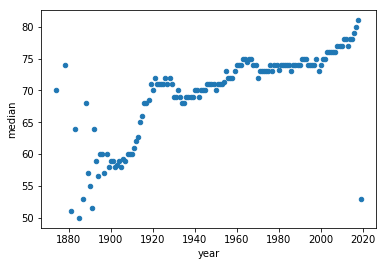

In [30]:
yr['year'] = yr['year'].apply(pd.to_numeric)
yr.plot.scatter(x='year',y='median')

# Post Credits: 5 min example of cluster